In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import biom

table = biom.load_table("data/macaque_tbl.biom")
table

28 x 24 <class 'biom.table.Table'> with 482 nonzero entries (71% dense)

In [4]:
import pandas as pd


metadata = pd.read_csv(
    "data/macaque_metadata.tsv",
    sep="\t",
    index_col=0
)
metadata.index = metadata.index.astype(str)
metadata.head()

,collection_device,collection_method,collection_timestamp,description,dna_extracted,elevation,elevation_units,emp_status,empo_1,empo_2,...,qiita_study_id,sample_source,sample_type,scientific_name,sex,taxon_id,time_point,time_point_units,title,tube_id
sample_name,,,,,,,,,,,,,,,,,,,,,
11835.11,OMNIgene.GUT kit,OMNIgene.GUT kit,2017-09-29,"Adult female human, occupatonal exposure to ma...",True,152,meters,EMP_Processed,Host-associated,Animal,...,11835,Kosum Phisai,feces,human gut metagenome,female,408170,not applicable,Not applicable,GAZER Thailand Microbiome,1132HE11
11835.12,OMNIgene.GUT kit,OMNIgene.GUT kit,2017-09-29,"Adult male human, occupatonal exposure to maca...",True,152,meters,EMP_Processed,Host-associated,Animal,...,11835,Kosum Phisai,feces,human gut metagenome,male,408170,not applicable,Not applicable,GAZER Thailand Microbiome,1608HE12
11835.13,OMNIgene.GUT kit,OMNIgene.GUT kit,2017-10-02,"Adult female, no macaque exposure",True,152,meters,EMP_Processed,Host-associated,Animal,...,11835,Mahasarakham University,feces,human gut metagenome,female,408170,not applicable,Not applicable,GAZER Thailand Microbiome,1125HC01
11835.14,OMNIgene.GUT kit,OMNIgene.GUT kit,2017-10-07,"Adult male, no macaque exposure",True,152,meters,EMP_Processed,Host-associated,Animal,...,11835,Mahasarakham University,feces,human gut metagenome,male,408170,not applicable,Not applicable,GAZER Thailand Microbiome,1189HC02
11835.15,OMNIgene.GUT kit,OMNIgene.GUT kit,2017-10-02,"Adult female, no macaque exposure",True,152,meters,EMP_Processed,Host-associated,Animal,...,11835,Mahasarakham University,feces,human gut metagenome,female,408170,not applicable,Not applicable,GAZER Thailand Microbiome,1152HC03


In [5]:
from birdman import NegativeBinomial

nb = NegativeBinomial(
    table=table,
    formula="host_common_name",
    metadata=metadata,
    num_iter=1000
)

In [6]:
nb.compile_model()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/gibs/projects/birdman/birdman/templates/negative_binomial


In [7]:
nb.fit_model()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [8]:
inference = nb.to_inference_object(
    params=["beta", "phi"],
    coords={
        "feature": nb.feature_names,
        "covariate": nb.colnames
    },
    dims={
        "beta": ["covariate", "feature"],
        "phi": ["feature"]
    },
    alr_params=["beta"],
    posterior_predictive="y_predict",
    log_likelihood="log_lik",
    include_observed_data=True
)

In [9]:
inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
import birdman.diagnostics as diag

r2_score(inference)

r2        0.794829
r2_std    0.293259
dtype: float64

In [21]:
diag.loo(inference)

Computed from 4000 by 672 log-likelihood matrix

         Estimate       SE
elpd_loo -2791.65    57.92
p_loo       74.15        -

There has been a warning during the calculation. Please check the results.

In [24]:
diag.rhat(inference)

<xarray.Dataset>
Dimensions:    (covariate: 2, feature: 28)
Coordinates:
  * feature    (feature) object 'OTU9' 'OTU15' 'OTU20' ... 'OTU688' 'OTU729'
  * covariate  (covariate) object 'Intercept' 'host_common_name[T.long-tailed...
Data variables:
    beta       (covariate, feature) float64 1.001 1.001 1.003 ... 1.0 1.001
    phi        (feature) float64 1.004 1.005 1.002 0.9995 ... 1.001 1.0 1.0

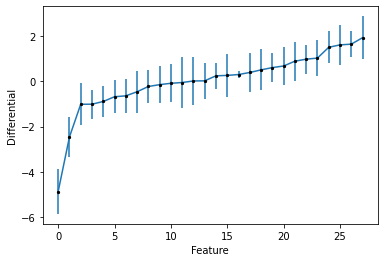

In [17]:
from birdman.visualization import plot_parameter_estimates, plot_posterior_predictive_checks

ax = plot_parameter_estimates(
    inference,
    parameter="beta",
    coord={"covariate": "host_common_name[T.long-tailed macaque]"}
)

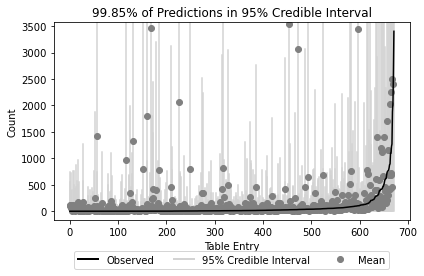

In [19]:
ax = plot_posterior_predictive_checks(inference)

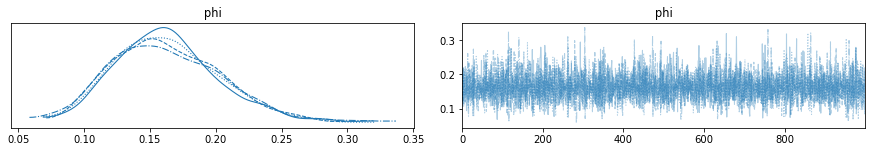

In [32]:
import arviz as az

ax = az.plot_trace(
    inference,
    var_names=["phi"],
    coords={"feature": "OTU9"},
    combined=False
)

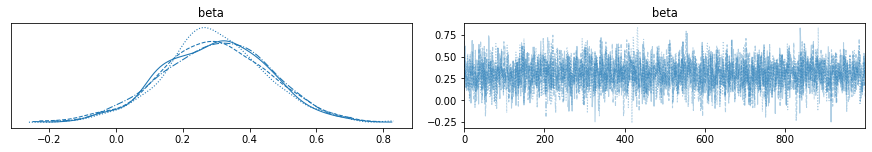

In [31]:
ax = az.plot_trace(
    inference,
    var_names=["beta"],
    coords={"feature": "OTU9", "covariate": "host_common_name[T.long-tailed macaque]"},
    combined=False
)